## Import libraries

In [24]:
import yfinance as yf

from copy import deepcopy as dc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Download data

In [25]:
stock_data = yf.Ticker("AMZN").history(period="max")
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-12 00:00:00-04:00,188.020004,188.350006,185.429993,186.889999,33984200,0.0,0.0
2024-06-13 00:00:00-04:00,186.089996,187.669998,182.669998,183.830002,39721500,0.0,0.0
2024-06-14 00:00:00-04:00,183.080002,183.720001,182.229996,183.660004,25456400,0.0,0.0


In [26]:
stock_data['Date'] = stock_data.index
stock_data = stock_data[['Date', 'Close']]
stock_data = stock_data.reset_index(drop=True)
stock_data

,Date,Close
0,1997-05-15 00:00:00-04:00,0.097917
1,1997-05-16 00:00:00-04:00,0.086458
2,1997-05-19 00:00:00-04:00,0.085417
3,1997-05-20 00:00:00-04:00,0.081771
4,1997-05-21 00:00:00-04:00,0.071354
...,...,...
6813,2024-06-12 00:00:00-04:00,186.889999
6814,2024-06-13 00:00:00-04:00,183.830002
6815,2024-06-14 00:00:00-04:00,183.660004
6816,2024-06-17 00:00:00-04:00,184.059998


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

<Axes: xlabel='Date'>

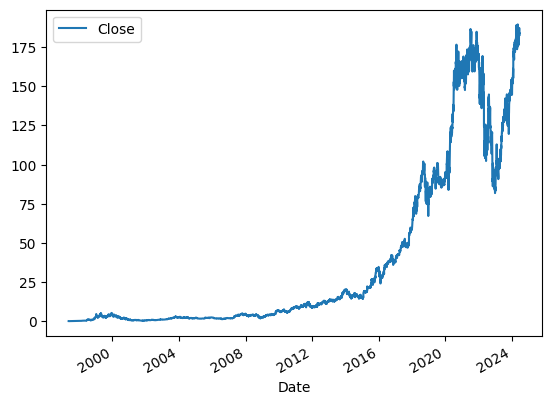

In [28]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.plot.line(x='Date', y='Close')

In [29]:
df = dc(stock_data)
df.set_index('Date', inplace=True)
df

,Close
Date,
1997-05-15 00:00:00-04:00,0.097917
1997-05-16 00:00:00-04:00,0.086458
1997-05-19 00:00:00-04:00,0.085417
1997-05-20 00:00:00-04:00,0.081771
1997-05-21 00:00:00-04:00,0.071354
...,...
2024-06-12 00:00:00-04:00,186.889999
2024-06-13 00:00:00-04:00,183.830002
2024-06-14 00:00:00-04:00,183.660004


## Create lookback columns

In [30]:
lookback = 7
for i in range(lookback):
    df[f'Close(t-{i + 1})'] = df['Close'].shift(i + 1)

df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-15 00:00:00-04:00,0.097917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16 00:00:00-04:00,0.086458,0.097917,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19 00:00:00-04:00,0.085417,0.086458,0.097917,NaN,NaN,NaN,NaN,NaN
1997-05-20 00:00:00-04:00,0.081771,0.085417,0.086458,0.097917,NaN,NaN,NaN,NaN
1997-05-21 00:00:00-04:00,0.071354,0.081771,0.085417,0.086458,0.097917,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-06-12 00:00:00-04:00,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999,179.339996,178.339996
2024-06-13 00:00:00-04:00,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999,179.339996
2024-06-14 00:00:00-04:00,183.660004,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999


In [31]:
df.dropna(inplace=True)
df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27 00:00:00-04:00,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28 00:00:00-04:00,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29 00:00:00-04:00,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30 00:00:00-04:00,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02 00:00:00-04:00,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2024-06-12 00:00:00-04:00,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999,179.339996,178.339996
2024-06-13 00:00:00-04:00,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999,179.339996
2024-06-14 00:00:00-04:00,183.660004,183.830002,186.889999,187.229996,187.059998,184.300003,185.000000,181.279999


In [32]:
data = df.to_numpy()
data

array([[7.91670009e-02, 7.50000030e-02, 6.97920024e-02, ...,
        8.54170024e-02, 8.64579976e-02, 9.79169980e-02],
       [7.65630007e-02, 7.91670009e-02, 7.50000030e-02, ...,
        8.17710012e-02, 8.54170024e-02, 8.64579976e-02],
       [7.52599984e-02, 7.65630007e-02, 7.91670009e-02, ...,
        7.13540018e-02, 8.17710012e-02, 8.54170024e-02],
       ...,
       [1.83660004e+02, 1.83830002e+02, 1.86889999e+02, ...,
        1.84300003e+02, 1.85000000e+02, 1.81279999e+02],
       [1.84059998e+02, 1.83660004e+02, 1.83830002e+02, ...,
        1.87059998e+02, 1.84300003e+02, 1.85000000e+02],
       [1.82809998e+02, 1.84059998e+02, 1.83660004e+02, ...,
        1.87229996e+02, 1.87059998e+02, 1.84300003e+02]])

## Scale data to (-1, 1)

In [33]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

scaled_data

array([[-0.99991201, -0.999956  , -1.        , ..., -0.99983503,
        -0.99982404, -0.99970306],
       [-0.9999395 , -0.99991201, -0.99994501, ..., -0.99987353,
        -0.99983503, -0.99982404],
       [-0.99995326, -0.9999395 , -0.99990102, ..., -0.99998351,
        -0.99987353, -0.99983503],
       ...,
       [ 0.93834111,  0.94013595,  0.97244367, ...,  0.94509855,
         0.9524891 ,  0.91321341],
       [ 0.94256426,  0.93834111,  0.94013628, ...,  0.97423851,
         0.94509855,  0.9524891 ],
       [ 0.92936671,  0.94256426,  0.93834145, ...,  0.97603334,
         0.97423851,  0.94509855]])

In [34]:
x = scaled_data[:, 1:]
y = scaled_data[:, 0]

x = dc(np.flip(x, axis=1))

x.shape, y.shape

((6811, 7), (6811,))

## Partition train and test data

In [35]:
split_index = int(len(x) * 0.95)
split_index

6470

In [36]:
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6470, 7), (341, 7), (6470,), (341,))

In [37]:
x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6470, 7, 1), (341, 7, 1), (6470, 1), (341, 1))

In [38]:
x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([6470, 7, 1]),
 torch.Size([341, 7, 1]),
 torch.Size([6470, 1]),
 torch.Size([341, 1]))

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
train_set = TimeSeriesDataset(x_train, y_train)
test_set = TimeSeriesDataset(x_test, y_test)

In [40]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

## Create LSTM class

In [41]:
class LSTM(nn.Module):
    def __init__(self, input, hidden, stacked):
        super().__init__()

        self.hidden = hidden
        self.stacked = stacked

        self.lstm = nn.LSTM(input, hidden, stacked, batch_first=True)

        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(self.stacked, batch_size, self.hidden).to(device)
        c0 = torch.zeros(self.stacked, batch_size, self.hidden).to(device)

        x, _ = self.lstm(x, (h0, c0))
        x = self.fc(x[:, -1, :])

        return x

In [42]:
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

## Train and validate

In [43]:
lr = 0.001
epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [44]:
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)

        loss = loss_fn(output, y_batch)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)

    print(f'Epoch: {epoch}\nTrain loss: {average_loss}')

    model.train(False)
    total_loss = 0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)

            loss = loss_fn(output, y_batch)
            total_loss += loss.item()

    average_loss = total_loss / len(test_loader)

    print(f'Test loss: {average_loss}\n')


Epoch: 1
Train loss: 0.1708086744726946
Test loss: 0.18043230142211542

Epoch: 2
Train loss: 0.012163155099641486
Test loss: 0.03451310641883703

Epoch: 3
Train loss: 0.0031225261426484786
Test loss: 0.010229521937700074

Epoch: 4
Train loss: 0.0013016231722388142
Test loss: 0.005728031220232052

Epoch: 5
Train loss: 0.0006627204897130816
Test loss: 0.0031595711956139316

Epoch: 6
Train loss: 0.000416634273593153
Test loss: 0.002395955051972785

Epoch: 7
Train loss: 0.0003443365391112708
Test loss: 0.0017211476859467273

Epoch: 8
Train loss: 0.0003304747594989345
Test loss: 0.0016456539980770851

Epoch: 9
Train loss: 0.00031486073934008154
Test loss: 0.00145756512012502

Epoch: 10
Train loss: 0.0002999808740196947
Test loss: 0.0012628614177546378



## Plot train results

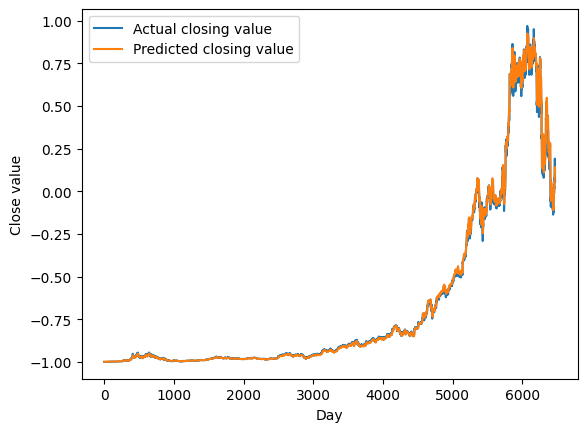

In [45]:
with torch.no_grad():
    train_predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual closing value')
plt.plot(train_predicted, label='Predicted closing value')

plt.xlabel('Day')
plt.ylabel('Close value')

plt.legend()
plt.show()

## Rescale data

In [46]:
temp = np.zeros((x_train.shape[0], lookback + 1))
temp[:, 0] = train_predicted.flatten()
temp = scaler.inverse_transform(temp)

rescaled_train_predictions = dc(temp[:, 0])
rescaled_train_predictions

array([  0.17580975,   0.17506456,   0.17468631, ..., 107.87513283,
       106.67445732, 105.43033741])

In [47]:
temp = np.zeros((x_train.shape[0], lookback + 1))
temp[:, 0] = y_train.flatten()
temp = scaler.inverse_transform(temp)

rescaled_y_train = dc(temp[:, 0])

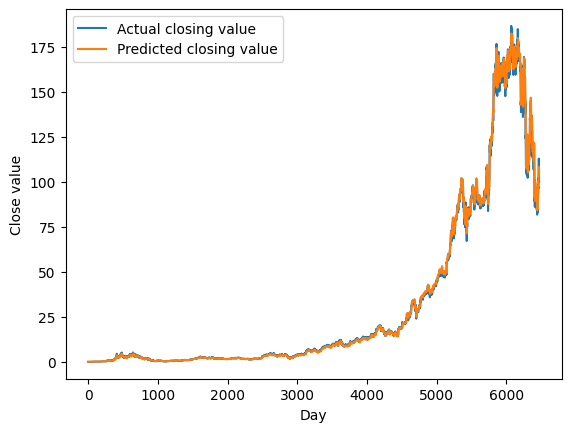

In [48]:
plt.plot(rescaled_y_train, label='Actual closing value')
plt.plot(rescaled_train_predictions, label='Predicted closing value')

plt.xlabel('Day')
plt.ylabel('Close value')

plt.legend()
plt.show()

## Plot test results

In [49]:
with torch.no_grad():
    test_predicted = model(x_test.to(device)).cpu().numpy()

temp = np.zeros((x_test.shape[0], lookback + 1))
temp[:, 0] = test_predicted.flatten()
temp = scaler.inverse_transform(temp)

rescaled_test_predictions = dc(temp[:, 0])
rescaled_test_predictions

array([103.38502385, 101.19044232,  99.56125475,  99.8682673 ,
       100.04273647, 100.84864264, 100.60726385,  99.93806315,
        98.29644012,  97.28161213,  96.72276546,  95.72019935,
        95.29098302,  95.14300786,  94.42289386,  93.73927473,
        94.29053395,  94.53660127,  94.59903689,  94.79110145,
        94.40246869,  93.37800961,  93.04736247,  93.85749849,
        95.06030232,  97.39558206,  98.97705023,  99.55072179,
       100.5551396 , 100.48591818, 100.26855222,  99.80565667,
        99.56864321,  99.05817645,  99.63366162, 100.9888497 ,
       102.50903391, 103.38916477, 104.42314205, 104.02611031,
       103.68549053, 103.44859985, 102.5324455 , 101.12443597,
       101.6134515 , 102.37154795, 103.03525847, 103.49853932,
       104.53777813, 104.99608536, 106.17410294, 106.99834123,
       106.23332349, 106.25710204, 107.89992191, 107.79801909,
       106.31470799, 105.73089723, 105.2848547 , 104.8938043 ,
       105.42118899, 106.38501899, 107.29092689, 109.03

In [50]:
temp = np.zeros((x_test.shape[0], lookback + 1))
temp[:, 0] = y_test.flatten()
temp = scaler.inverse_transform(temp)

rescaled_y_test = dc(temp[:, 0])

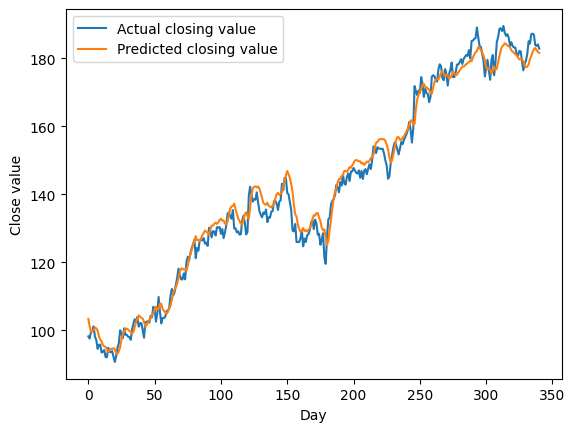

In [51]:
plt.plot(rescaled_y_test, label='Actual closing value')
plt.plot(rescaled_test_predictions, label='Predicted closing value')

plt.xlabel('Day')
plt.ylabel('Close value')

plt.legend()
plt.show()